# **浮島発電所の発電量を予測してみる**

### **必要な関数・ライブラリ等の準備**

In [48]:
# データ加工・処理・分析モジュール
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random

%matplotlib inline

import time

In [49]:
def set_time(dataframe, col_name):
    '''
    to_datetimeを使うための前処理
    '''
    dataframe[col_name] = dataframe[col_name].map(lambda x : transform_time(x))
    return dataframe

In [50]:
def transform_time(x):
    '''
    set_time内で使う関数
    to_datetimeで24時をサポートしないので00に変更する処理
    '''
    str_x = str(x)
    res = ''
    if str(x)[8:10] == '24':
        res = str_x[0:4] + '-' + str_x[4:6] + '-' + str_x[6:8] + ' 00:'+str_x[10:12] 
    else:
        res = str_x[0:4] + '-' + str_x[4:6] + '-' + str_x[6:8] + ' '+ str_x[8:10] +':'+str_x[10:12]
    return res

In [51]:
def normalize_array(x):
    '''
    min, max, min-max正規化を行なった配列(np.array)を返す
    '''
    x = np.array(x)
    x_min = x.min()
    x_max = x.max()
    normalized = (x - x_min) / (x_max - x_min) 
    return x_min, x_max, normalized

In [52]:
def denormalize_array(normalized_x, x_min, x_max):
    '''
    正規化前のmin, maxを用いて元のスケールに戻す
    '''
    normalized_x = np.array(normalized_x)
    denormalize_array = (normalized_x) * (x_max - x_min) + x_min
    return denormalize_array

In [53]:
def standardize_array(x):
    '''
    mean, sigma, 標準化された配列を返す
    '''
    x = np.array(x)
    x_mean = x.mean()
    x_sigma = x.std()
    standardized_array = (x - x_mean) / x_sigma
    return x_mean, x_sigma, standardized_array

In [54]:
def destandardize_array(standardized_x, x_mean, x_sigma):
    '''
    標準化前のmean, sigma用いて元のスケールに戻す
    '''
    standardized_x = np.array(standardized_x)
    destandardized_array = (standardized_x) * x_sigma + x_mean
    return destandardized_array

In [55]:
def get_chunked_data(x, chunk_size):
    '''
    rnnに突っ込むためのchunk_sizeごとに区切った系列データを作る
    '''
    input_list = []
    for i in range(0, len(x) - chunk_size + 1):
        input_list.append(x[i : i + chunk_size])
    input_list = np.array(input_list)
    return input_list

In [91]:
def drop_nan(X, Y):
    '''
    正解データがnanであるデータの組を削除
    '''
    mask = np.isnan(Y)
    X = X[~mask]
    Y = Y[~mask]
    return X, Y

## **データの準備**

In [56]:
# 正解データを作る
try:
    true_output = pd.read_csv('data/processed_data/output_by30.tsv', delimiter = '\t')
    true_output['datetime'] = true_output['datetime'].map(lambda x : pd.to_datetime(x))
    
except:
    # train_kwhをエクセル等で開くとdatetimeが指数表示に直される可能性がある
    # その場合うまくいかないので201201010120の形になってることを確認する必要あり
    true_output = pd.read_csv('data/raw_data/train_kwh.tsv', delimiter = '\t')

    # datetimeの行をpd.Timestampのインスタンスに変更
    true_output = set_time(true_output, 'datetime')
    true_output['datetime'] = true_output['datetime'].map(lambda x : pd.to_datetime(x))

    # 30分ごとに合計を集計
    true_output = true_output.set_index('datetime').groupby(pd.TimeGrouper(freq='1800s', closed='left')).sum()

    true_output.to_csv('data/processed_data/output_by30.tsv', sep='\t') 
    
    true_output = pd.read_csv('data/processed_data/output_by30.tsv', delimiter = '\t')
    true_output['datetime'] = true_output['datetime'].map(lambda x : pd.to_datetime(x))
    
true_output.head()

,datetime,SOLA01,SOLA02,SOLA03
0,2012-01-01 00:00:00,0,0.0,NaN
1,2012-01-01 00:30:00,0,0.0,NaN
2,2012-01-01 01:00:00,0,0.0,NaN
3,2012-01-01 01:30:00,0,0.0,NaN
4,2012-01-01 02:00:00,0,0.0,NaN


In [57]:
# 10分単位の発電量のデータを取ってくる
output_data = pd.read_csv('data/raw_data/train_kwh.tsv', delimiter = '\t')

# datetimeの行をpd.Timestampのインスタンスに変更
output_data = set_time(output_data, 'datetime')
output_data['datetime'] = output_data['datetime'].map(lambda x : pd.to_datetime(x))
    
output_data.head()

,datetime,SOLA01,SOLA02,SOLA03
0,2012-01-01 00:10:00,0,0.0,NaN
1,2012-01-01 00:20:00,0,0.0,NaN
2,2012-01-01 00:30:00,0,0.0,NaN
3,2012-01-01 00:40:00,0,0.0,NaN
4,2012-01-01 00:50:00,0,0.0,NaN


In [107]:
# 予測する発電所番号を決める
target_place = 2
model_name = "model_"+str(target_place)

In [58]:
# アメダスデータの読み込み

if target_place == 1 or target_place == 2:
    # 横浜アメダスのデータを使って予測する, amd_46106
    # 各amdidはamd_masterに記載されている
    amd_data = pd.read_csv('data/raw_data/amd_46106.tsv', delimiter = '\t')
    amd_data = set_time(amd_data, 'datetime')
    amd_data['datetime'] = amd_data['datetime'].map(lambda x : pd.to_datetime(x))
    amd_data.head()
else target_place == 3:
    # 甲府アメダスのデータを使って予測する, amd_49142
    # 各amdidはamd_masterに記載されている
    amd_data = pd.read_csv('data/raw_data/amd_49142.tsv', delimiter = '\t')
    amd_data = set_time(amd_data, 'datetime')
    amd_data['datetime'] = amd_data['datetime'].map(lambda x : pd.to_datetime(x))
    amd_data.head()

,datetime,pr,f_pr,max_ws,f_max_ws,ave_wv,f_ave_wv,ave_ws,f_ave_ws,max_tp,f_max_tp,min_tp,f_min_tp,sl,f_sl,sd,f_sd,dsd,f_dsd
0,2012-01-01 00:10:00,0,0,48.0,0,36.0,0,32.0,0,57.0,0,56.0,0,0.0,2,0.0,0,0.0,0
1,2012-01-01 00:20:00,0,0,48.0,0,36.0,0,35.0,0,56.0,0,55.0,0,0.0,2,0.0,0,0.0,0
2,2012-01-01 00:30:00,0,0,49.0,0,36.0,0,32.0,0,56.0,0,55.0,0,0.0,2,0.0,0,0.0,0
3,2012-01-01 00:40:00,0,0,49.0,0,35.0,0,35.0,0,56.0,0,54.0,0,0.0,2,0.0,0,0.0,0
4,2012-01-01 00:50:00,0,0,61.0,0,35.0,0,34.0,0,55.0,0,53.0,0,0.0,2,0.0,0,0.0,0


In [65]:
# モデル構築のためにデータを分割する

# 日射量の欠損値を一つ前の値で置換/output_data
amd_data['sl'] = amd_data['sl'].fillna(method='bfill')
amd_data['max_tp'] = amd_data['max_tp'].fillna(method='bfill')

# 学習に必要なデータ
# 2012/01/01 00:10 ~ 2015/12/30 20:00のamdデータを用いて
# 2012/01/03 03:50 ~ 2015/12/31 23:50のデータを予測する
train_x_startID = amd_data[amd_data['datetime'] == pd.to_datetime('2012-01-01 00:10')].index[0]
train_x_endID = amd_data[amd_data['datetime'] == pd.to_datetime('2015-12-30 20:00')].index[0]
train_y_startID = amd_data[amd_data['datetime'] == pd.to_datetime('2012-01-03 03:50')].index[0]
train_y_endID = amd_data[amd_data['datetime'] == pd.to_datetime('2015-12-31 23:50')].index[0]

train_amd_data = amd_data[['sl', 'max_tp']][train_x_startID:(train_x_endID+1)]
train_output_data = np.array(output_data['SOLA0'+str(target_place)][train_y_startID:(train_y_endID+1)])

# 予測に必要なデータ
# 2015/12/29 20:30 ~ 2017/3/30 20:00のamdデータを用いて
# 2016/01/01 00:00 ~ 2017/3/31 23:50のoutputデータを予測する
test_startID = amd_data[amd_data['datetime'] == pd.to_datetime('2015-12-29 20:50')].index[0]
test_endID = amd_data[amd_data['datetime'] == pd.to_datetime('2017-3-30 20:00')].index[0]

test_amd_data = amd_data[['sl', 'max_tp']][test_startID:(test_endID+1)]

In [99]:
# rnnに突っ込むための準備

chunk_size = 144

# rnnに突っ込むためにmin-max正規化しておく
normalized_amd = (train_amd_data - train_amd_data.min()) / (train_amd_data.max() - train_amd_data.min())
normalized_amd = np.array(normalized_amd)
normalized_test_amd = (test_amd_data - test_amd_data.min()) / (test_amd_data.max() - test_amd_data.min())
normalized_test_amd = np.array(normalized_test_amd)

#時系列データのリストにする
input_list = get_chunked_data(normalized_amd, chunk_size)

# outputがnanである学習ペアを取り除く
input_list, train_output_data = drop_nan(input_list, train_output_data)

# outputのmin_max正規化
output_min, output_max, normalized_output = normalize_array(train_output_data)

# testデータの入力を用意
test_input_list = get_chunked_data(normalized_test_amd, chunk_size)

# RNNに突っ込むためにデータを整形
X = np.array(input_list).reshape(len(input_list), chunk_size, input_list.shape[2])
Y = np.array(normalized_output).reshape(len(input_list), 1)
X_predict = np.array(test_input_list).reshape(len(test_input_list), chunk_size, test_input_list.shape[2])

/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 210073 but corresponding boolean dimension is 209353
  


### **モデルの構築**

前日の20時までの横浜のアメダスの日射量データを用いて翌日の00:00~23:50を予測する

前日の20時までのデータしか使えないので川崎近くのアメダスデータを使うのは予測として適切か疑問だったのでとりあえず1日程度ラグがありそうな(※要出典)ここのデータをつかう

(例)

8/17の00:00 ~ 23:50を予測するとき

8/17の23:50を8/15 20:10 ~ 8/16 20:00

8/17の23:40を8/15 20:00 ~ 8/16 19:50

....

8/17の00:00を8/14 20:00 ~ 8/15 20:10で予測する

参考サイト：http://www.madopro.net/entry/char_level_lm_with_simple_rnn

　　　　　　https://qiita.com/yukiB/items/f6314d2861fc8d9b739f

          https://www.tensorflow.org/install/migration
          

In [101]:
class simpleLSTM:
    def __init__(self, X, Y, epochs = 100, magni = 1, model_name = "test_model"):
        # 学習データと検証用データに分けておく
        X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=int((X.shape[0] * 0.1)))
        self.X = X # 入力
        self.Y = Y # 教師
        self.X_val = X_val # 検証用
        self.Y_val = Y_val #検証用
        
        '''
        諸変数の設定
        '''
        self.input_layer_size = self.X.shape[2] #入力層の数、一つ一つのデータはslの値ひとつだけなので1
        self.hidden_layer_size = 200 # 隠れ層の数、適当
        self.output_layer_size = 1 #出力層の数、求める値は時間あたりの発電量の値1つなので1
        self.batch_size = 200 #バッチサイズ、適当
        self.chunk_size = self.X.shape[1] # 一回の系列データの長さ
        self.learning_rate = 0.01 # 学習率 適当
        self.forget_bias = 0.9  # 忘却率
        self.magni = magni #lossの拡大倍率
        self.epochs = epochs #エポック数
        
        # 学習データの保存
        self.model_name = str(model_name)
        
        
    def shuffle(self):
        '''
        ミニバッチかする際にランダムにシャッフル
        '''
        idx = [i for i in range(self.X.shape[0])]
        np.random.shuffle(idx)
        xs = np.array([[y for y in list(self.X[r])] for r in idx])
        ys = np.array([self.Y[r] for r in idx])
        return xs, ys
        
    def inference(self, input_ph, inistate_ph):
        '''
        グラフの構築
        '''
        
        # 重みとバイアスの初期化
        hidden_w = tf.Variable(tf.truncated_normal([self.input_layer_size, self.hidden_layer_size], stddev=0.01), name='hidden_w')
        hidden_b = tf.Variable(tf.truncated_normal([self.hidden_layer_size]), name='hidden_b')
        output_w = tf.Variable(tf.truncated_normal([self.hidden_layer_size, self.output_layer_size], stddev=0.01), name='output_w')
        output_b = tf.Variable(tf.truncated_normal([self.output_layer_size]), name='output_b')
        
        #　input_phの整型  
        in1 = tf.transpose(input_ph, [1, 0, 2]) 
        in2 = tf.reshape(in1, [-1, self.input_layer_size]) 
        in3 = tf.matmul(in2, hidden_w) + hidden_b
        in4 = tf.split(in3, self.chunk_size, 0)
          
        # BasicLSTMCellを定義
        cell = tf.contrib.rnn.BasicLSTMCell(self.hidden_layer_size, forget_bias=self.forget_bias, state_is_tuple=False)
        rnn_outputs, states = tf.contrib.rnn.static_rnn(cell, in4, initial_state=inistate_ph)
        output = tf.matmul(rnn_outputs[-1], output_w) + output_b
        results = [hidden_w, output_w, hidden_w, hidden_b]
        return output, states, results
        
    def loss(self, output_ph, actual_ph):
        '''
        お題と同じmean absolute errorを仕様
        '''
        cost = tf.reduce_mean(tf.abs(self.magni*(output_ph - actual_ph)))
        tf.summary.scalar('loss', cost)
        return cost
    
    def training(self, cost):
        '''
        adamを仕様beta1, beta2は元論文の推奨値を仕様
        '''
        with tf.name_scope("training") as scope:
            optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate, beta1=0.9, beta2=0.999).minimize(cost)
            return optimizer
    
    def train(self):
        '''
        学習
        '''
        random.seed(0)
        np.random.seed(0)
        tf.set_random_seed(0)
        n_batch = self.X.shape[0] // self.batch_size
        
        with tf.Graph().as_default():
            # 変数の用意
            input_ph = tf.placeholder('float', [None, self.chunk_size, self.input_layer_size], name='input')
            actual_ph = tf.placeholder('float', [None, self.output_layer_size], name='actual_value')
            inistate_ph = tf.placeholder('float', [None, self.hidden_layer_size * 2], name='inistate')

            prediction, state, weights = self.inference(input_ph, inistate_ph)
            cost = self.loss(prediction, actual_ph)
            optimizer = self.training(cost)

            # TensorBoardで可視化する
            summary = tf.summary.merge_all()
            # 初期化
            init = tf.global_variables_initializer()
                
            # ここから学習
            with tf.Session() as sess:
                # 学習したモデルも保存しておく
                saver = tf.train.Saver()
                summary_writer = tf.summary.FileWriter("/tmp/tensorflow_log", graph=sess.graph)
                sess.run(init)

                for epoch in range(self.epochs):
                    X_, Y_ = self.shuffle()
                    for i in range(n_batch):
                        start = i * self.batch_size
                        end = start + self.batch_size
                        inputs  = X_[start:end]
                        actuals = Y_[start:end]
                        train_dict = {
                            input_ph:      inputs,
                            actual_ph:     actuals,
                            inistate_ph:     np.zeros((self.batch_size, self.hidden_layer_size * 2)),
                        }
                    
                    sess.run(optimizer, feed_dict=train_dict)

                    if (epoch) % (self.epochs//10) == 0:
                        val_dict = {
                            input_ph:      self.X_val,
                            actual_ph:     self.Y_val,
                            inistate_ph:     np.zeros((self.X_val.shape[0], self.hidden_layer_size * 2)),
                        }
                        summary_str, train_loss = sess.run([summary, cost], feed_dict=val_dict)
                        print("train#%d, validation loss: %e" % (epoch, train_loss))
                        summary_writer.add_summary(summary_str, epoch)
                        
                    datas = sess.run(weights)
                    saver.save(sess, "./data/model/" + str(self.model_name) + ".ckpt")
                    
                datas = sess.run(weights)
                saver.save(sess, "./data/model/" + str(self.model_name) + ".ckpt")
                
    def predict(self, X_predict, model_name = "test_model"):
        '''
        予測期間に該当するデータから予測
        '''
        # 予測に使う変数の用意
        tf.reset_default_graph()
        input_ph = tf.placeholder("float", [None, self.chunk_size, self.input_layer_size], name='input')
        inistate_ph = tf.placeholder("float", [None, self.hidden_layer_size * 2], name='inistate')
        prediction, state, weights = self.inference(input_ph, inistate_ph)
        pre_dict = {
            input_ph: X_predict,
            inistate_ph: np.zeros((X_predict.shape[0], self.hidden_layer_size*2))
        }
        
        # 初期化
        init = tf.global_variables_initializer()

        with tf.Session() as sess:
            # 保存したモデルをロード
            saver = tf.train.Saver()
            saver.restore(sess, "./data/model/" + str(model_name) + ".ckpt")

            # ロードしたモデルを使って予測結果を計算
            expected_output = sess.run([prediction], feed_dict=pre_dict)


        return expected_output

In [102]:
model_01 = simpleLSTM(X, Y, epochs = 50, magni = 1000, model_name = model_name)

In [103]:
model_01.train()

train#0, validation loss: 2.960726e+02
train#5, validation loss: 2.454100e+02
train#10, validation loss: 1.335964e+02
train#15, validation loss: 2.816827e+02
train#20, validation loss: 1.402000e+02
train#25, validation loss: 2.230655e+02
train#30, validation loss: 2.329813e+02
train#35, validation loss: 2.383373e+02
train#40, validation loss: 1.401257e+02
train#45, validation loss: 1.583693e+02


In [109]:
batch_size = 10000
n_batch = len(X) // batch_size
processed_predict = np.array([])
for i in range(n_batch+1):
    s_idx = i * batch_size
    e_idx = (i+1) * batch_size
    if e_idx > len(X_predict):
        e_idx = len(X_predict)
    predict = model_01.predict(X_predict[s_idx:e_idx], model_name)
    predict = np.array(predict).reshape(len(predict[0]))
    tmp_predict = denormalize_array(predict, output_min, output_max)
    processed_predict = np.r_[processed_predict, tmp_predict]

NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ./data/model/model_2.ckpt
	 [[Node: save/RestoreV2_2 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save/Const_0, save/RestoreV2_2/tensor_names, save/RestoreV2_2/shape_and_slices)]]

Caused by op 'save/RestoreV2_2', defined at:
  File "/Users/kyojin/anaconda/envs/tf/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/kyojin/anaconda/envs/tf/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-109-f41e4c279673>", line 9, in <module>
    predict = model_01.predict(X_predict[s_idx:e_idx], model_name)
  File "<ipython-input-101-0af06b32056b>", line 158, in predict
    saver = tf.train.Saver()
  File "/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 1051, in __init__
    self.build()
  File "/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 1081, in build
    restore_sequentially=self._restore_sequentially)
  File "/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 675, in build
    restore_sequentially, reshape)
  File "/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 402, in _AddRestoreOps
    tensors = self.restore_op(filename_tensor, saveable, preferred_shard)
  File "/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 242, in restore_op
    [spec.tensor.dtype])[0])
  File "/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/tensorflow/python/ops/gen_io_ops.py", line 668, in restore_v2
    dtypes=dtypes, name=name)
  File "/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2395, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1264, in __init__
    self._traceback = _extract_stack()

NotFoundError (see above for traceback): Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ./data/model/model_2.ckpt
	 [[Node: save/RestoreV2_2 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save/Const_0, save/RestoreV2_2/tensor_names, save/RestoreV2_2/shape_and_slices)]]


In [40]:
# 2016/01/01 00:00 ~ 2017/3/31 23:50の予測データを書き出す
s_idx = amd_data[amd_data['datetime'] == pd.to_datetime('2016/01/01 00:00')].index[0]
e_idx = amd_data[amd_data['datetime'] == pd.to_datetime('2017/3/31 23:50')].index[0]
predict_data = pd.DataFrame({"datetime":amd_data['datetime'][s_idx:e_idx+1], "expected_output":1})
predict_data.index = np.arange(len(predict_data))
predict_data.to_csv('data/predicted_data/predict_SOLA01.tsv', sep = '\t')

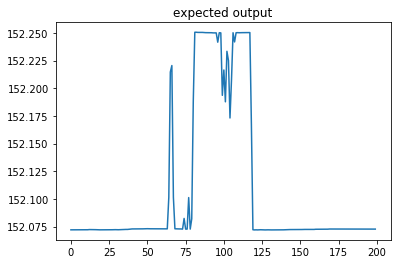

In [143]:
plt.plot(processed_predict[0:200])
plt.title("expected output")

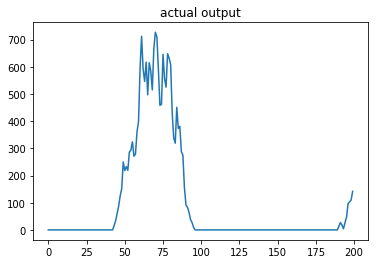

In [144]:
plt.plot(output_data['SOLA01'][0:200])
plt.title("actual output")

In [59]:
compare = output_data[['SOLA01', 'SOLA02']]

In [60]:
# compare = compare.dropna()
dif = np.array(abs(compare['SOLA01'] - compare['SOLA02']))

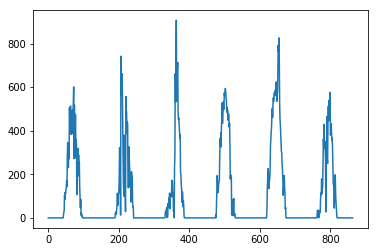

In [61]:
plt.plot(dif[0:1000])